## Pretrained Vectors - Euclidean Distance (L2)

We train traditional (non neural network) classifiers from Scikit-Learn by looking up the vectors for each given image pair. These image vectors were [generated using pre-trained networks from Keras Model Zoo](http://localhost:8888/notebooks/pretrained-nets-vectorizers.ipynb). In this notebook, we merge the vectors for the image pair by computing the Euclidean Distance (L2) between them.

In [1]:
from __future__ import division, print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos")

In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if image_groups.has_key(group_name):
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "rb")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def preprocess_data(vector_file, train_size=0.7):
    xdata, ydata = [], []
    vec_dict = load_vectors(vector_file)
    for image_triple in image_triples:
        X1 = vec_dict[image_triple[0]]
        X2 = vec_dict[image_triple[1]]
#         xdata.append(np.multiply(X1, X2) / (np.linalg.norm(X1, 2) * np.linalg.norm(X2, 2)))
        xdata.append(np.power(np.subtract(X1, X2), 2))
        ydata.append(image_triple[2])
    X, y = np.array(xdata), np.array(ydata)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    return Xtrain, Xtest, ytrain, ytest

def cross_validate(X, y, clf, k=10):
    best_score, best_clf = 0.0, None
    kfold = KFold(k)
    for kid, (train, test) in enumerate(kfold.split(X, y)):
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf.fit(Xtrain, ytrain)
        ytest_ = clf.predict(Xtest)
        score = accuracy_score(ytest_, ytest)
        print("fold {:d}, score: {:.3f}".format(kid, score))
        if score > best_score:
            best_score = score
            best_clf = clf
    return best_clf, best_score

def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(accuracy_score(ytest_, ytest)))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(classification_report(ytest_, ytest))
    
def get_model_file(data_dir, vec_name, clf_name):
    return os.path.join(data_dir, "models", "{:s}-{:s}-l2.pkl"
                        .format(vec_name, clf_name))

def save_model(model, model_file):
    joblib.dump(model, model_file)

In [4]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 300 pos + 300 neg = 600 total image triples
Generated 1100 pos + 1100 neg = 2200 total image triples
Generated 1800 pos + 1800 neg = 3600 total image triples
Generated 2072 pos + 2072 neg = 4144 total image triples


In [5]:
NUM_VECTORIZERS = 5
NUM_CLASSIFIERS = 4
scores = np.zeros((NUM_VECTORIZERS, NUM_CLASSIFIERS))

# VGG-16 Vectors

In [6]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg16-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 4096) (1244, 4096) (2900,) (1244,)


## Naive Bayes

In [7]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "nb"))

fold 0, score: 0.834
fold 1, score: 0.838
fold 2, score: 0.783
fold 3, score: 0.821
fold 4, score: 0.817
fold 5, score: 0.841
fold 6, score: 0.834
fold 7, score: 0.828
fold 8, score: 0.793
fold 9, score: 0.824

Accuracy Score: 0.799

Confusion Matrix
[[507 136]
 [114 487]]

Classification Report
             precision    recall  f1-score   support

          0       0.82      0.79      0.80       643
          1       0.78      0.81      0.80       601

avg / total       0.80      0.80      0.80      1244



## SVM

In [8]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "svm"))

fold 0, score: 0.886
fold 1, score: 0.883
fold 2, score: 0.855
fold 3, score: 0.886
fold 4, score: 0.893
fold 5, score: 0.886
fold 6, score: 0.931
fold 7, score: 0.886
fold 8, score: 0.872
fold 9, score: 0.879

Accuracy Score: 0.865

Confusion Matrix
[[508  55]
 [113 568]]

Classification Report
             precision    recall  f1-score   support

          0       0.82      0.90      0.86       563
          1       0.91      0.83      0.87       681

avg / total       0.87      0.86      0.87      1244



## XGBoost

In [9]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "xgb"))

fold 0, score: 0.921
fold 1, score: 0.928
fold 2, score: 0.921
fold 3, score: 0.907
fold 4, score: 0.931
fold 5, score: 0.938
fold 6, score: 0.931
fold 7, score: 0.921
fold 8, score: 0.907
fold 9, score: 0.934

Accuracy Score: 0.924

Confusion Matrix
[[569  43]
 [ 52 580]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.93      0.92       612
          1       0.93      0.92      0.92       632

avg / total       0.92      0.92      0.92      1244



## Random Forest

In [10]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "rf"))

fold 0, score: 0.890
fold 1, score: 0.893
fold 2, score: 0.866
fold 3, score: 0.859
fold 4, score: 0.910
fold 5, score: 0.859
fold 6, score: 0.879
fold 7, score: 0.886
fold 8, score: 0.841
fold 9, score: 0.886

Accuracy Score: 0.878

Confusion Matrix
[[581 112]
 [ 40 511]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.84      0.88       693
          1       0.82      0.93      0.87       551

avg / total       0.88      0.88      0.88      1244



# VGG-19

In [11]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg19-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 4096) (1244, 4096) (2900,) (1244,)


## Naive Bayes

In [12]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "nb"))

fold 0, score: 0.800
fold 1, score: 0.803
fold 2, score: 0.793
fold 3, score: 0.752
fold 4, score: 0.810
fold 5, score: 0.814
fold 6, score: 0.797
fold 7, score: 0.838
fold 8, score: 0.845
fold 9, score: 0.786

Accuracy Score: 0.799

Confusion Matrix
[[486 103]
 [147 508]]

Classification Report
             precision    recall  f1-score   support

          0       0.77      0.83      0.80       589
          1       0.83      0.78      0.80       655

avg / total       0.80      0.80      0.80      1244



## SVM

In [13]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "svm"))

fold 0, score: 0.886
fold 1, score: 0.897
fold 2, score: 0.900
fold 3, score: 0.855
fold 4, score: 0.893
fold 5, score: 0.879
fold 6, score: 0.900
fold 7, score: 0.876
fold 8, score: 0.914
fold 9, score: 0.876

Accuracy Score: 0.891

Confusion Matrix
[[543  46]
 [ 90 565]]

Classification Report
             precision    recall  f1-score   support

          0       0.86      0.92      0.89       589
          1       0.92      0.86      0.89       655

avg / total       0.89      0.89      0.89      1244



## XGBoost

In [14]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "xgb"))

fold 0, score: 0.886
fold 1, score: 0.938
fold 2, score: 0.914
fold 3, score: 0.928
fold 4, score: 0.910
fold 5, score: 0.921
fold 6, score: 0.928
fold 7, score: 0.928
fold 8, score: 0.921
fold 9, score: 0.903

Accuracy Score: 0.930

Confusion Matrix
[[580  34]
 [ 53 577]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.94      0.93       614
          1       0.94      0.92      0.93       630

avg / total       0.93      0.93      0.93      1244



## Random Forest

In [15]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "rf"))

fold 0, score: 0.821
fold 1, score: 0.879
fold 2, score: 0.876
fold 3, score: 0.834
fold 4, score: 0.862
fold 5, score: 0.848
fold 6, score: 0.876
fold 7, score: 0.876
fold 8, score: 0.886
fold 9, score: 0.841

Accuracy Score: 0.871

Confusion Matrix
[[572  99]
 [ 61 512]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.85      0.88       671
          1       0.84      0.89      0.86       573

avg / total       0.87      0.87      0.87      1244



# Inception V3

In [16]:
VECTOR_FILE = os.path.join(DATA_DIR, "inception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [17]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "nb"))

fold 0, score: 0.883
fold 1, score: 0.883
fold 2, score: 0.862
fold 3, score: 0.869
fold 4, score: 0.907
fold 5, score: 0.862
fold 6, score: 0.862
fold 7, score: 0.917
fold 8, score: 0.869
fold 9, score: 0.893

Accuracy Score: 0.887

Confusion Matrix
[[576  89]
 [ 51 528]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.87      0.89       665
          1       0.86      0.91      0.88       579

avg / total       0.89      0.89      0.89      1244



## SVM

In [18]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "svm"))

fold 0, score: 0.924
fold 1, score: 0.862
fold 2, score: 0.903
fold 3, score: 0.890
fold 4, score: 0.879
fold 5, score: 0.883
fold 6, score: 0.866
fold 7, score: 0.924
fold 8, score: 0.876
fold 9, score: 0.903

Accuracy Score: 0.876

Confusion Matrix
[[520  47]
 [107 570]]

Classification Report
             precision    recall  f1-score   support

          0       0.83      0.92      0.87       567
          1       0.92      0.84      0.88       677

avg / total       0.88      0.88      0.88      1244



## XGBoost

In [19]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "xgb"))

fold 0, score: 0.934
fold 1, score: 0.945
fold 2, score: 0.928
fold 3, score: 0.910
fold 4, score: 0.941
fold 5, score: 0.921
fold 6, score: 0.914
fold 7, score: 0.914
fold 8, score: 0.921
fold 9, score: 0.969

Accuracy Score: 0.932

Confusion Matrix
[[591  48]
 [ 36 569]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.92      0.93       639
          1       0.92      0.94      0.93       605

avg / total       0.93      0.93      0.93      1244



## Random Forest

In [20]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "rf"))

fold 0, score: 0.866
fold 1, score: 0.883
fold 2, score: 0.883
fold 3, score: 0.841
fold 4, score: 0.883
fold 5, score: 0.876
fold 6, score: 0.869
fold 7, score: 0.893
fold 8, score: 0.862
fold 9, score: 0.907

Accuracy Score: 0.879

Confusion Matrix
[[588 112]
 [ 39 505]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.84      0.89       700
          1       0.82      0.93      0.87       544

avg / total       0.89      0.88      0.88      1244



# ResNet 50

In [21]:
VECTOR_FILE = os.path.join(DATA_DIR, "resnet-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [22]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "nb"))

fold 0, score: 0.852
fold 1, score: 0.831
fold 2, score: 0.872
fold 3, score: 0.872
fold 4, score: 0.866
fold 5, score: 0.893
fold 6, score: 0.872
fold 7, score: 0.859
fold 8, score: 0.845
fold 9, score: 0.855

Accuracy Score: 0.834

Confusion Matrix
[[543 123]
 [ 83 495]]

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.82      0.84       666
          1       0.80      0.86      0.83       578

avg / total       0.84      0.83      0.83      1244



## SVM

In [23]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "svm"))

fold 0, score: 0.914
fold 1, score: 0.910
fold 2, score: 0.903
fold 3, score: 0.917
fold 4, score: 0.910
fold 5, score: 0.897
fold 6, score: 0.872
fold 7, score: 0.890
fold 8, score: 0.893
fold 9, score: 0.910

Accuracy Score: 0.890

Confusion Matrix
[[527  38]
 [ 99 580]]

Classification Report
             precision    recall  f1-score   support

          0       0.84      0.93      0.88       565
          1       0.94      0.85      0.89       679

avg / total       0.89      0.89      0.89      1244



## XGBoost

In [24]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "xgb"))

fold 0, score: 0.952
fold 1, score: 0.917
fold 2, score: 0.945
fold 3, score: 0.948
fold 4, score: 0.959
fold 5, score: 0.979
fold 6, score: 0.934
fold 7, score: 0.938
fold 8, score: 0.910
fold 9, score: 0.931

Accuracy Score: 0.932

Confusion Matrix
[[577  36]
 [ 49 582]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.94      0.93       613
          1       0.94      0.92      0.93       631

avg / total       0.93      0.93      0.93      1244



## Random Forest

In [25]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "rf"))

fold 0, score: 0.866
fold 1, score: 0.872
fold 2, score: 0.852
fold 3, score: 0.910
fold 4, score: 0.866
fold 5, score: 0.852
fold 6, score: 0.869
fold 7, score: 0.834
fold 8, score: 0.869
fold 9, score: 0.859

Accuracy Score: 0.861

Confusion Matrix
[[563 110]
 [ 63 508]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.84      0.87       673
          1       0.82      0.89      0.85       571

avg / total       0.86      0.86      0.86      1244



# Xception

In [26]:
VECTOR_FILE = os.path.join(DATA_DIR, "xception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [27]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "nb"))

fold 0, score: 0.838
fold 1, score: 0.883
fold 2, score: 0.876
fold 3, score: 0.855
fold 4, score: 0.852
fold 5, score: 0.855
fold 6, score: 0.855
fold 7, score: 0.869
fold 8, score: 0.872
fold 9, score: 0.821

Accuracy Score: 0.850

Confusion Matrix
[[556 127]
 [ 60 501]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.81      0.86       683
          1       0.80      0.89      0.84       561

avg / total       0.86      0.85      0.85      1244



## SVM

In [28]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "svm"))

fold 0, score: 0.928
fold 1, score: 0.934
fold 2, score: 0.941
fold 3, score: 0.934
fold 4, score: 0.952
fold 5, score: 0.859
fold 6, score: 0.931
fold 7, score: 0.934
fold 8, score: 0.934
fold 9, score: 0.934

Accuracy Score: 0.932

Confusion Matrix
[[573  42]
 [ 43 586]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.93      0.93       615
          1       0.93      0.93      0.93       629

avg / total       0.93      0.93      0.93      1244



## XGBoost

In [29]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "xgb"))

fold 0, score: 0.945
fold 1, score: 0.934
fold 2, score: 0.903
fold 3, score: 0.914
fold 4, score: 0.934
fold 5, score: 0.893
fold 6, score: 0.903
fold 7, score: 0.931
fold 8, score: 0.924
fold 9, score: 0.921

Accuracy Score: 0.922

Confusion Matrix
[[583  64]
 [ 33 564]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.90      0.92       647
          1       0.90      0.94      0.92       597

avg / total       0.92      0.92      0.92      1244



## Random Forest

In [30]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "rf"))

fold 0, score: 0.817
fold 1, score: 0.862
fold 2, score: 0.848
fold 3, score: 0.807
fold 4, score: 0.841
fold 5, score: 0.814
fold 6, score: 0.821
fold 7, score: 0.838
fold 8, score: 0.828
fold 9, score: 0.824

Accuracy Score: 0.816

Confusion Matrix
[[555 168]
 [ 61 460]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.77      0.83       723
          1       0.73      0.88      0.80       521

avg / total       0.83      0.82      0.82      1244



In [31]:
scores

array([[ 0.84137931,  0.93103448,  0.93793103,  0.91034483],
       [ 0.84482759,  0.9137931 ,  0.93793103,  0.8862069 ],
       [ 0.91724138,  0.92413793,  0.96896552,  0.90689655],
       [ 0.89310345,  0.91724138,  0.97931034,  0.91034483],
       [ 0.88275862,  0.95172414,  0.94482759,  0.86206897]])

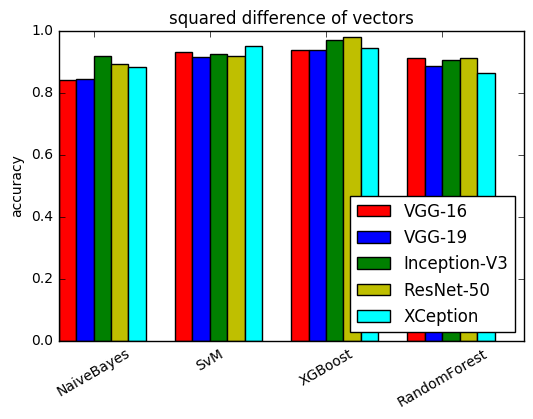

In [32]:
width=0.15
plt.bar(np.arange(NUM_CLASSIFIERS), scores[0], width, color="r", label="VGG-16")
plt.bar(np.arange(NUM_CLASSIFIERS)+width, scores[1], width, color="b", label="VGG-19")
plt.bar(np.arange(NUM_CLASSIFIERS)+2*width, scores[2], width, color="g", label="Inception-V3")
plt.bar(np.arange(NUM_CLASSIFIERS)+3*width, scores[3], width, color="y", label="ResNet-50")
plt.bar(np.arange(NUM_CLASSIFIERS)+4*width, scores[4], width, color="cyan", label="XCeption")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xticks(np.arange(NUM_CLASSIFIERS)+2*width, ["NaiveBayes", "SvM", "XGBoost", "RandomForest"],
          rotation=30)
plt.title("squared difference of vectors")